<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Dataforst%C3%A5else-og-unders%C3%B8kelse-Pradeep/Bioco_Dataprosessering%2C_Dataforst%C3%A5else_og_Dataunders%C3%B8kelse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataforståelse og Dataundersøkelse

Lasting av nødvendige bibiotek og pakker

In [1]:
!pip install hoggorm
!pip install hoggormPlot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 664.4 kB/s eta 0:00:00


Importering av nødvendige bibliotek og pakker

In [2]:
import pandas as pd
import numpy as np

import copy
import datetime

import hoggorm as ho
import hoggormplot as hop

import seaborn as sns
import matplotlib.pyplot as plt

Importering av data og omgjøring til DataFrame

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Velger første kolonne med dato og tid som index
bioco_rå_data = pd.read_csv('/content/drive/MyDrive/MasterV24/BiocoData.csv',
                            header=0,
                            sep=';',
                            index_col=0)

Mounted at /content/drive


Formattering av datasett før videre undersøkelse

In [4]:
# Gjør om index med dato og tid til riktig format
bioco_rå_data.index = pd.to_datetime(bioco_rå_data.index,
                                     format='%d-%m-%Y %H:%M:%S.%f')

Sjekking av kontinuitet i tidsereidata

In [5]:
# Lager lister for å lagre start- og slutttidspunkt på kontinuerlige tidserier
tid_observasjon_start = list()
tid_observasjon_slutt = list ()

# Legger til første observasjon i listen med startstider
tid_observasjon_start.append(bioco_rå_data.index[0])

# Går igjennom datasettet og lagrer slutt- og startstid på tidsintervaller
# mer enn et minutt
for i in range(1, len(bioco_rå_data.index)):
  tidsdiff = bioco_rå_data.index[i] - bioco_rå_data.index[i-1]
  if tidsdiff.total_seconds() > 60:
    tid_observasjon_slutt.append(bioco_rå_data.index[i-1])
    tid_observasjon_start.append(bioco_rå_data.index[i])

# Legger til siste observasjonstid i datasettet
tid_observasjon_slutt.append(bioco_rå_data.index[-1])

# Får oversikt over kontinuerlige datasett
for i,j in zip(tid_observasjon_start, tid_observasjon_slutt):
  i_week = i.isocalendar().week
  print("Uke {}: Tidsintervallet {} til {} er kontinuerlig tidserie".format(i_week, i, j))

Uke 44: Tidsintervallet 2022-10-31 15:30:00 til 2022-11-02 05:19:00 er kontinuerlig tidserie
Uke 44: Tidsintervallet 2022-11-02 10:47:00 til 2022-11-05 00:04:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-07 16:24:00 til 2022-11-08 23:57:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-09 01:39:00 til 2022-11-09 06:37:00 er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-09 11:11:00 til 2022-11-12 03:59:00 er kontinuerlig tidserie
Uke 46: Tidsintervallet 2022-11-14 18:01:00 til 2022-11-18 06:15:00 er kontinuerlig tidserie
Uke 46: Tidsintervallet 2022-11-18 08:45:00 til 2022-11-19 03:44:00 er kontinuerlig tidserie
Uke 47: Tidsintervallet 2022-11-21 16:23:00 til 2022-11-23 06:05:00 er kontinuerlig tidserie
Uke 47: Tidsintervallet 2022-11-23 08:59:00 til 2022-11-23 13:59:00 er kontinuerlig tidserie
Uke 47: Tidsintervallet 2022-11-23 20:15:00 til 2022-11-26 00:49:00 er kontinuerlig tidserie
Uke 48: Tidsintervallet 2022-11-28 14:38:00 til 2022-11-30 04:29:00 er

Utelukking av kolonner i datasett før videre undersøkelse

In [6]:
# Dropper kolonner "product_SampleID" og "testset" som ikke er relevant
bioco_data = bioco_rå_data.drop(columns=['product_sampleID', 'testset'])

# Dropper kolonne "RawMaterialMix" som er lite informativt
bioco_data.drop(columns=['RawMaterialMix'],
                inplace = True)

# Dropper kolonne "RawMaterialPercentage" som er produkt av RawMatFlow og WaterFlow
bioco_data.drop(columns=['RawMatPercent'],
                inplace = True)

# Dropper kolonner "Brix", "Yield" og "Yield_withoutNIR", da "BrixAdjusted"
# dekker samme informasjon
bioco_data.drop(columns=['Brix', 'Yield', 'Yield_withoutNIR'],
                inplace = True)

Informasjon om antall faktiske observasjoner og datatyper for hver kolonne

In [7]:
bioco_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43251 entries, 2022-10-31 15:30:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeCode      43251 non-null  object 
 1   RawMatFlow      43196 non-null  float64
 2   WaterFlow       43196 non-null  float64
 3   NIRfat          29064 non-null  float64
 4   NIRprotein      27520 non-null  float64
 5   NIRash          29275 non-null  float64
 6   NIRwater        29293 non-null  float64
 7   TT07            43201 non-null  float64
 8   TT08            43206 non-null  float64
 9   PT03            43226 non-null  float64
 10  TT20            43226 non-null  float64
 11  TT09            43236 non-null  float64
 12  TT12            43251 non-null  float64
 13  Collagen        99 non-null     float64
 14  Mw              540 non-null    float64
 15  SmallMolecules  540 non-null    float64
 16  BrixAdjusted    540 non-null    float64
d

Behandling av kategorisk variabel "EnzymeCode"

In [8]:
# Koverterer "EnzymeCode" fra kategorisk variabel til numeriske varaibler for
# hver respektive enzymtype
bioco_data = pd.get_dummies(bioco_data,
                            columns=["EnzymeCode"],
                            prefix=["EnzymeType"] )

# Reorgoniserer kolonnene, slik at enzymtype-informasjonen er de fremste
# kolonnene
kolonne_rekkefølge = bioco_data.columns[-6:].to_list() + bioco_data.columns[:-6].to_list()
bioco_data = bioco_data[kolonne_rekkefølge]

# Datafordeling

## Fordeling i hele datasett

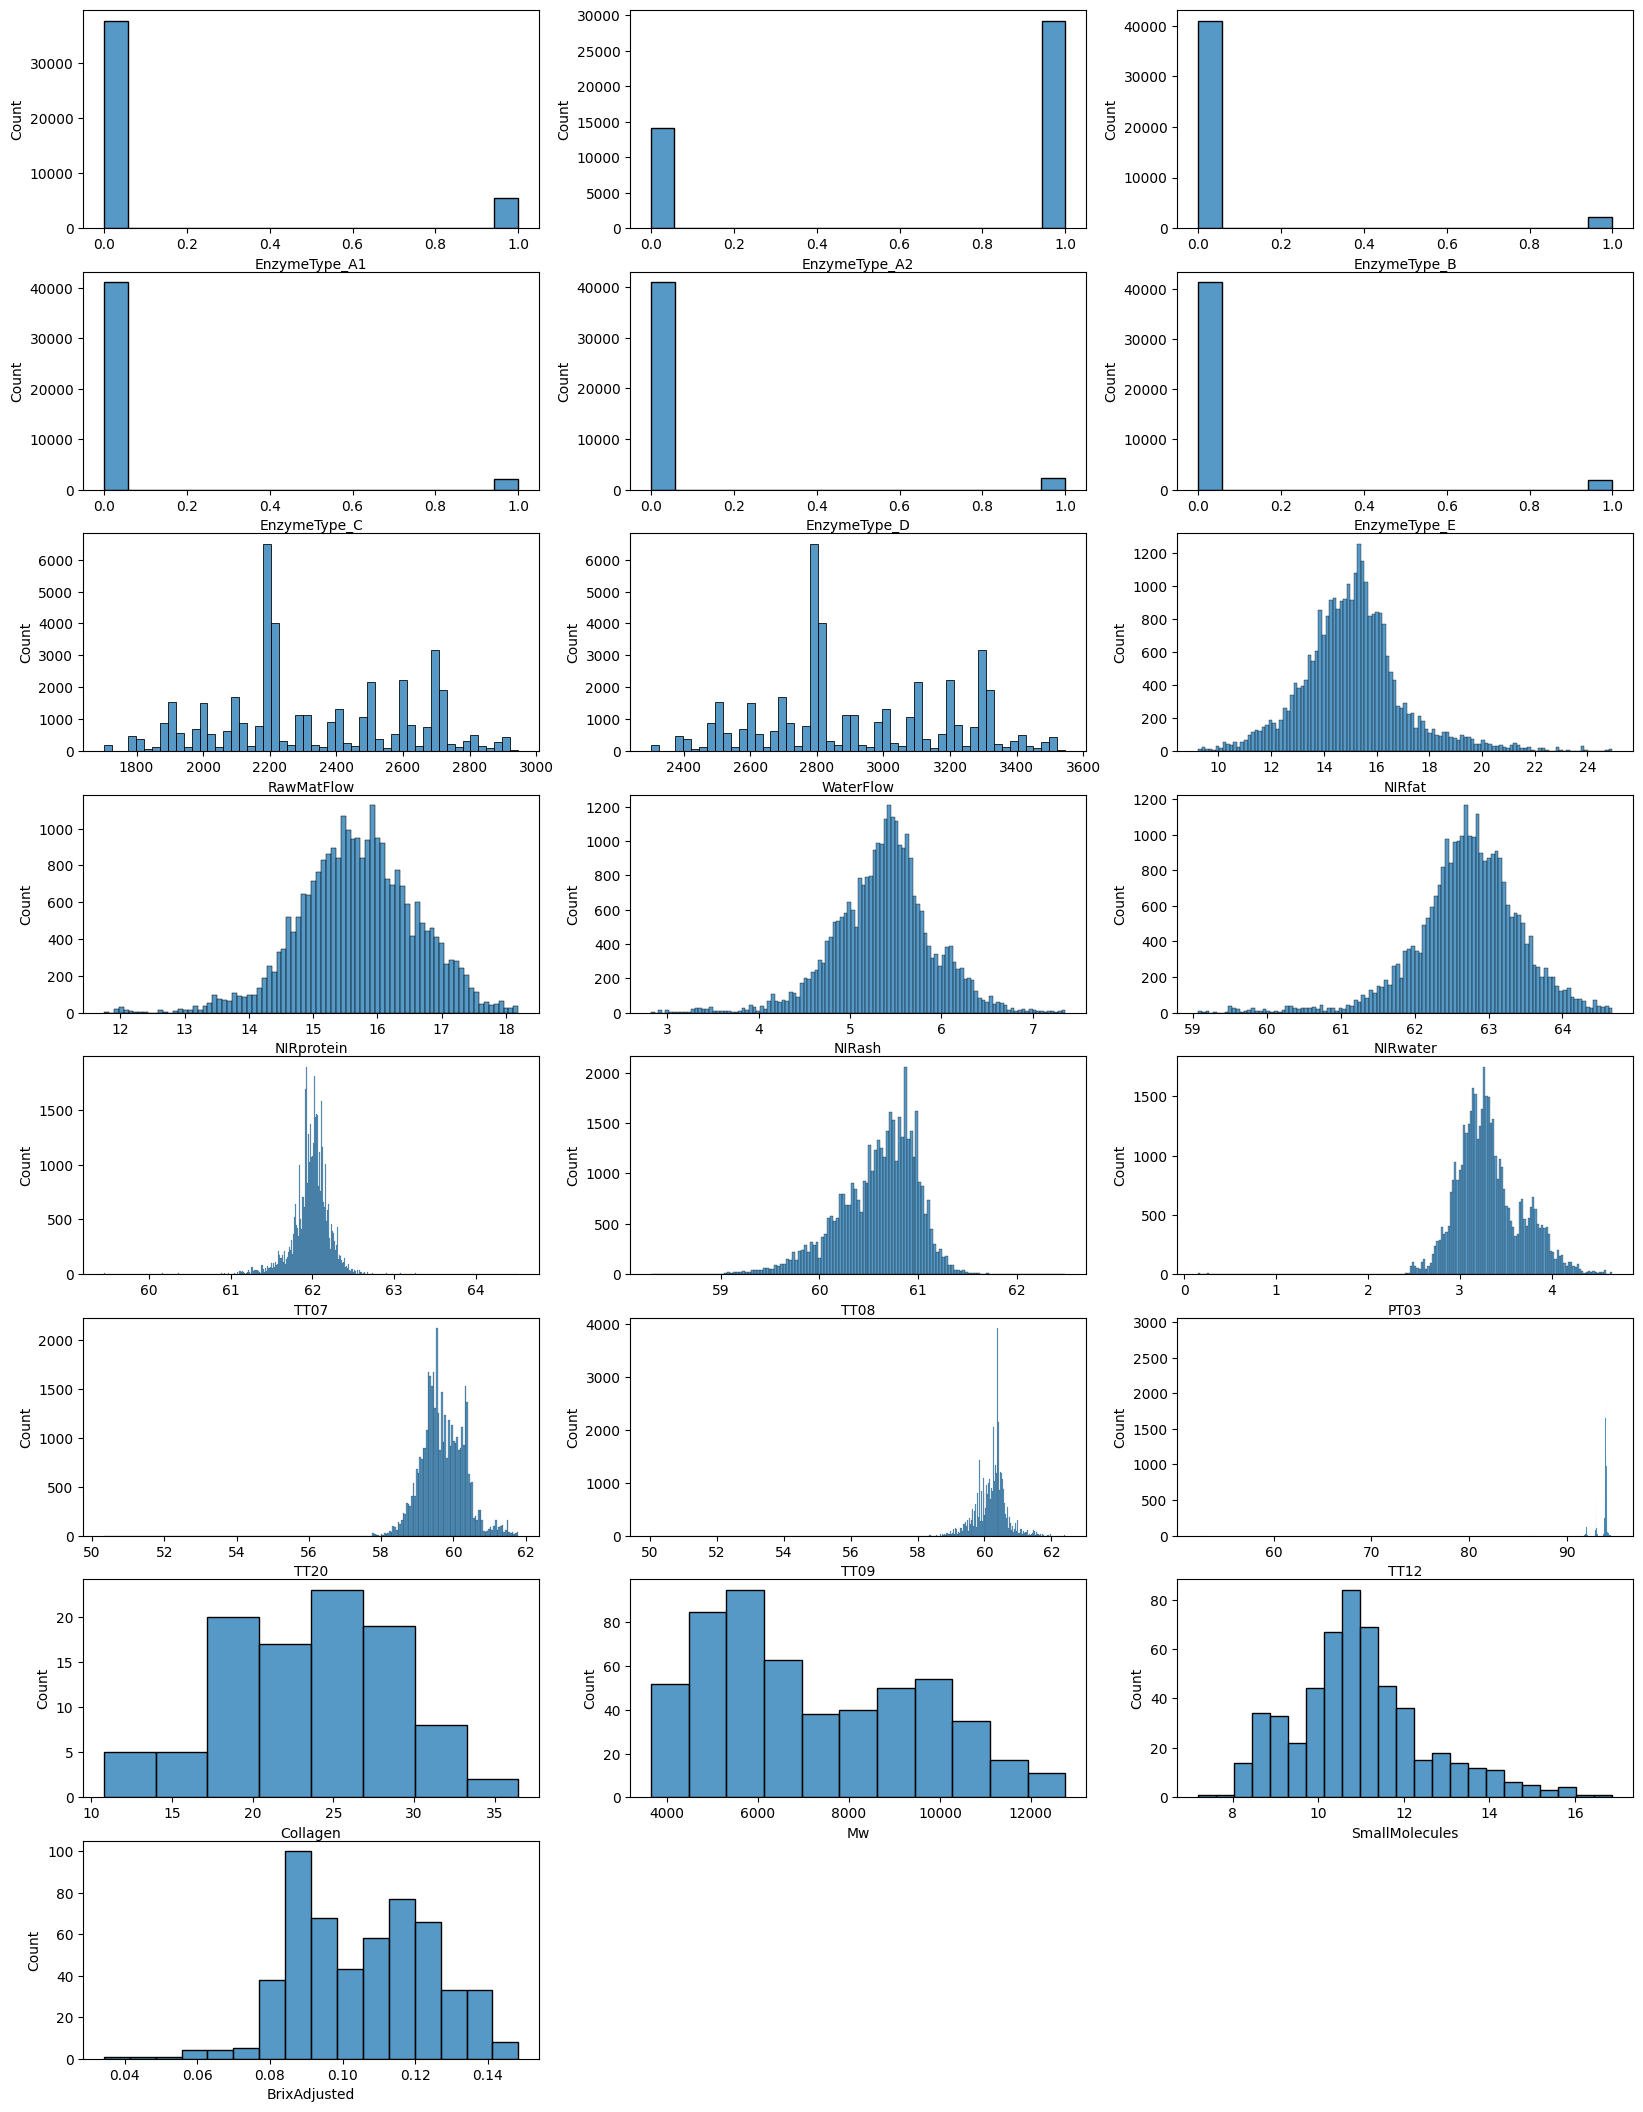

In [9]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(bioco_data.columns)
rute_nett = fig.add_gridspec(9,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), bioco_data):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.histplot(x=indeks, data = bioco_data)
  i += 1

## Fordeling i markert del av datasett

In [10]:
# Lager et for Collagen med mindre markeringer enn resterende kvalitesmålinger
collagen_markert = copy.deepcopy(bioco_data)

# Lager et for de resterende kvalitetsmålinger
kvalitetsmålinger_markert = copy.deepcopy(bioco_data)

# Fjerner rader uten markeringer for begge datasettene
collagen_markert.dropna(subset=['Collagen'],
                        inplace=True)

kvalitetsmålinger_markert.dropna(subset=['Mw', 'SmallMolecules', 'BrixAdjusted'],
                                 inplace=True)

Fordeling i datasett med Collagen som markert respons

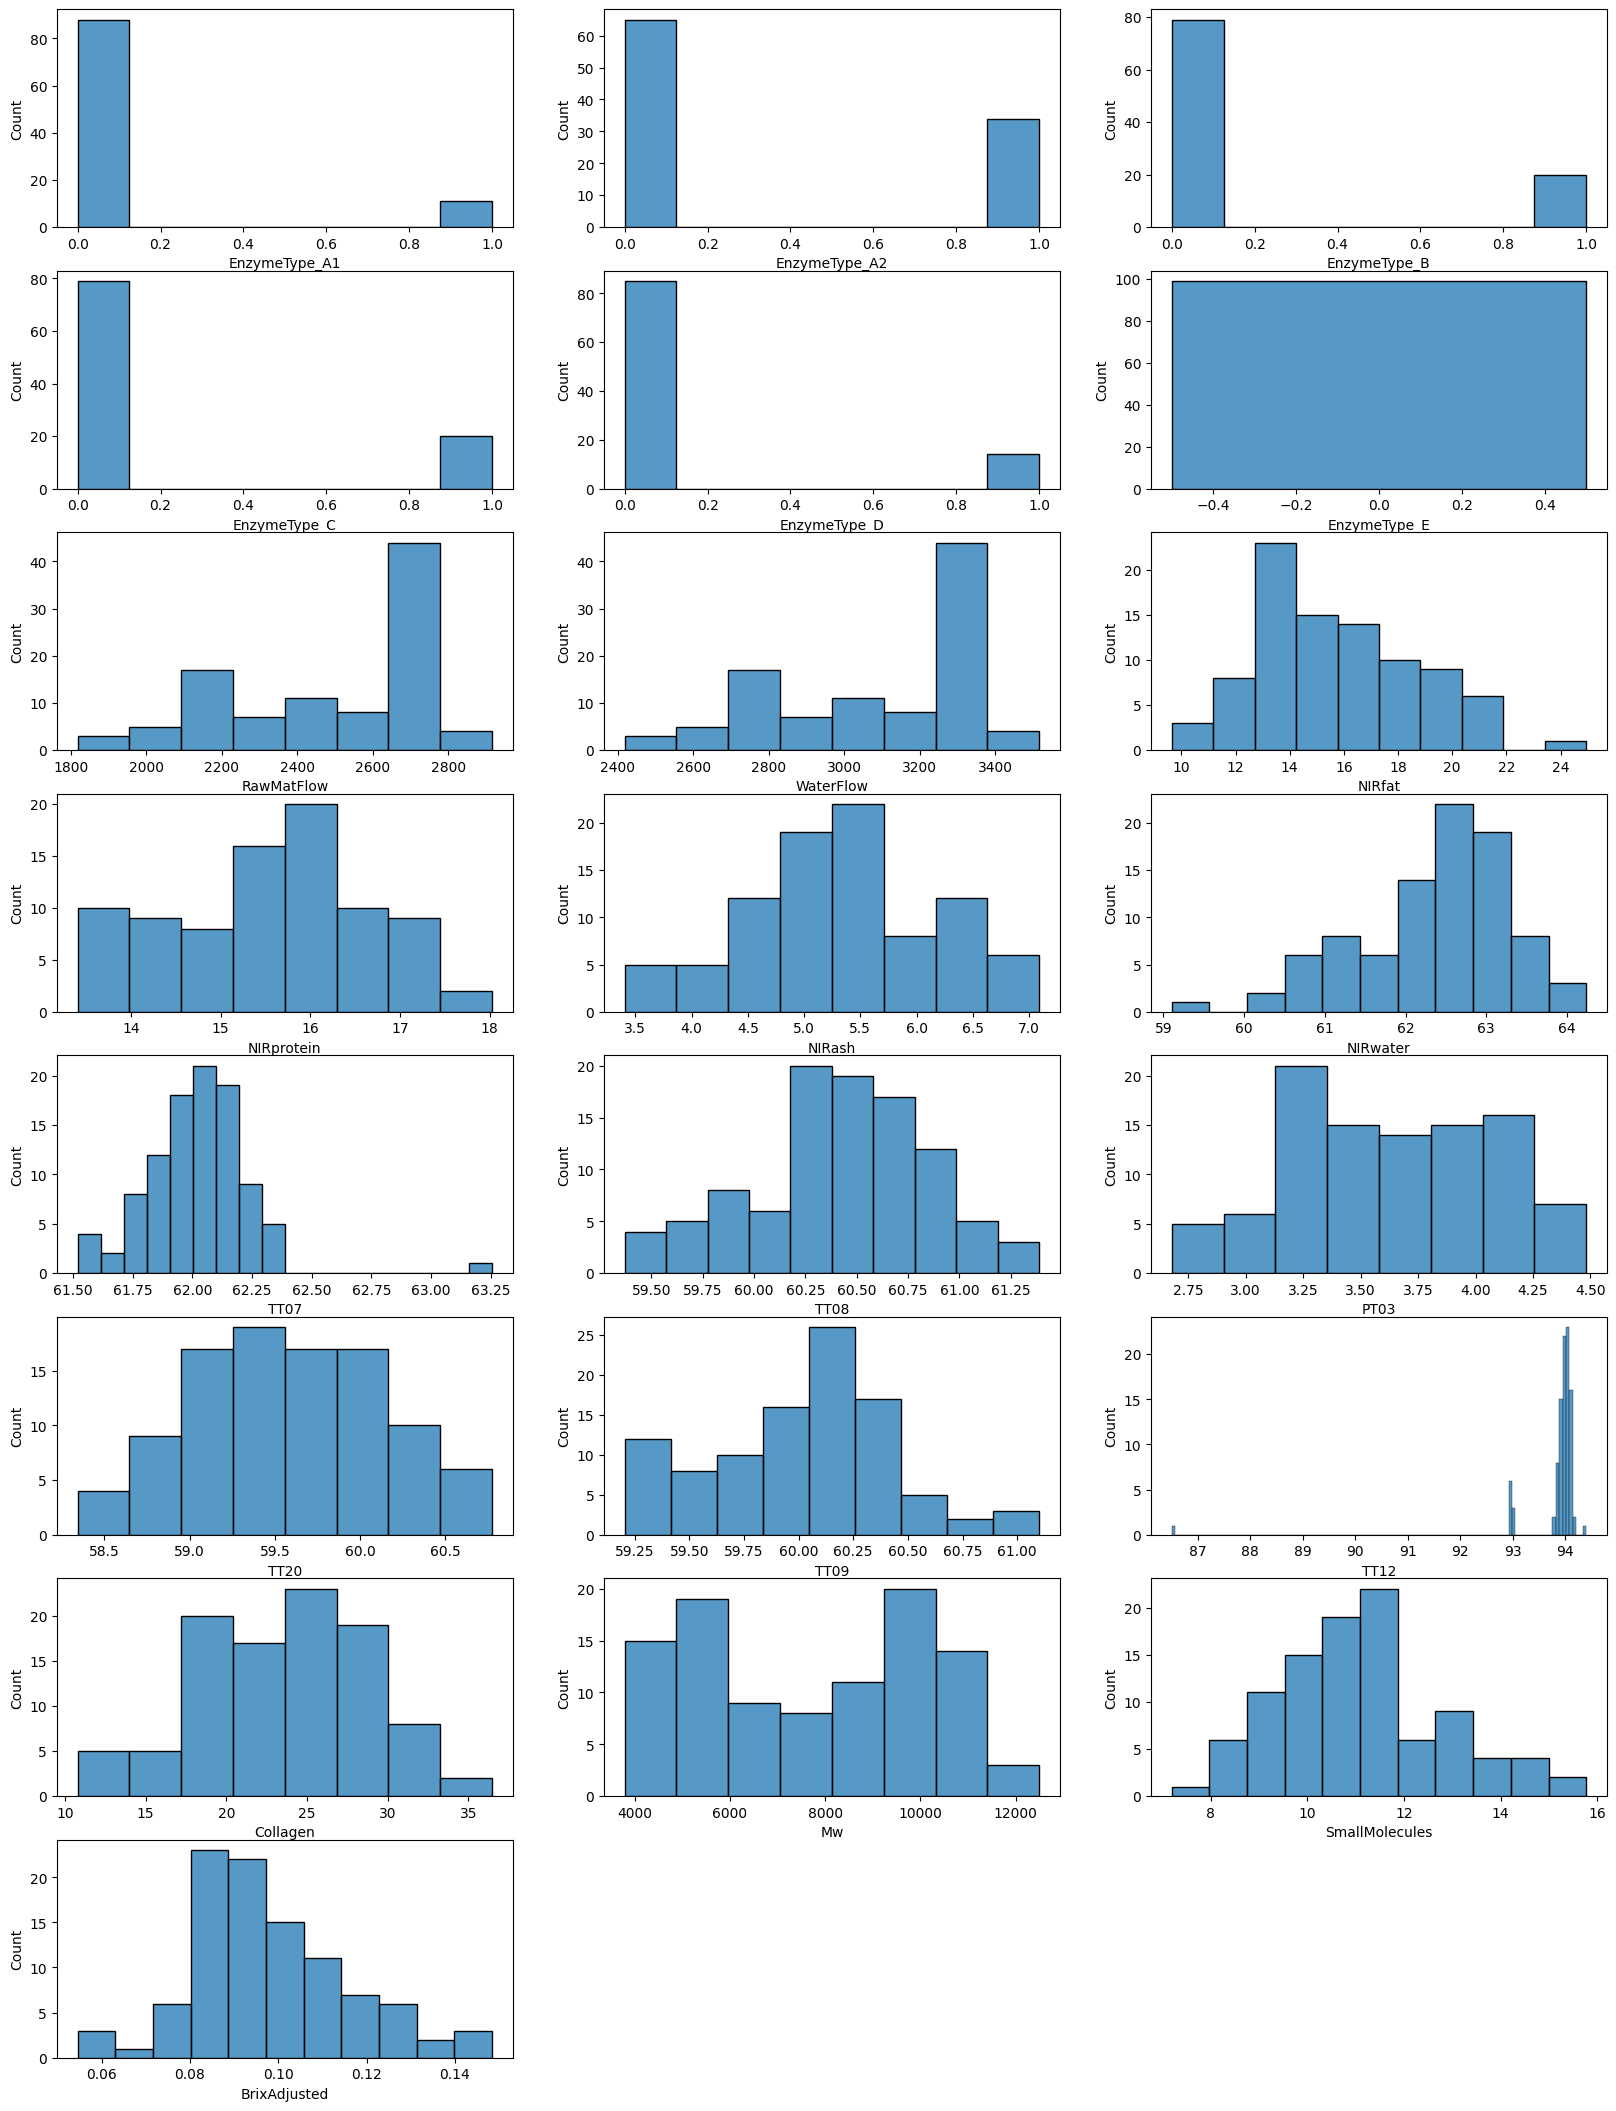

In [11]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(collagen_markert.columns)
rute_nett = fig.add_gridspec(9,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), collagen_markert):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.histplot(x=indeks, data = collagen_markert)
  i += 1

Fordeling i datasett med resterende kvalitetsmålinger som markert respons

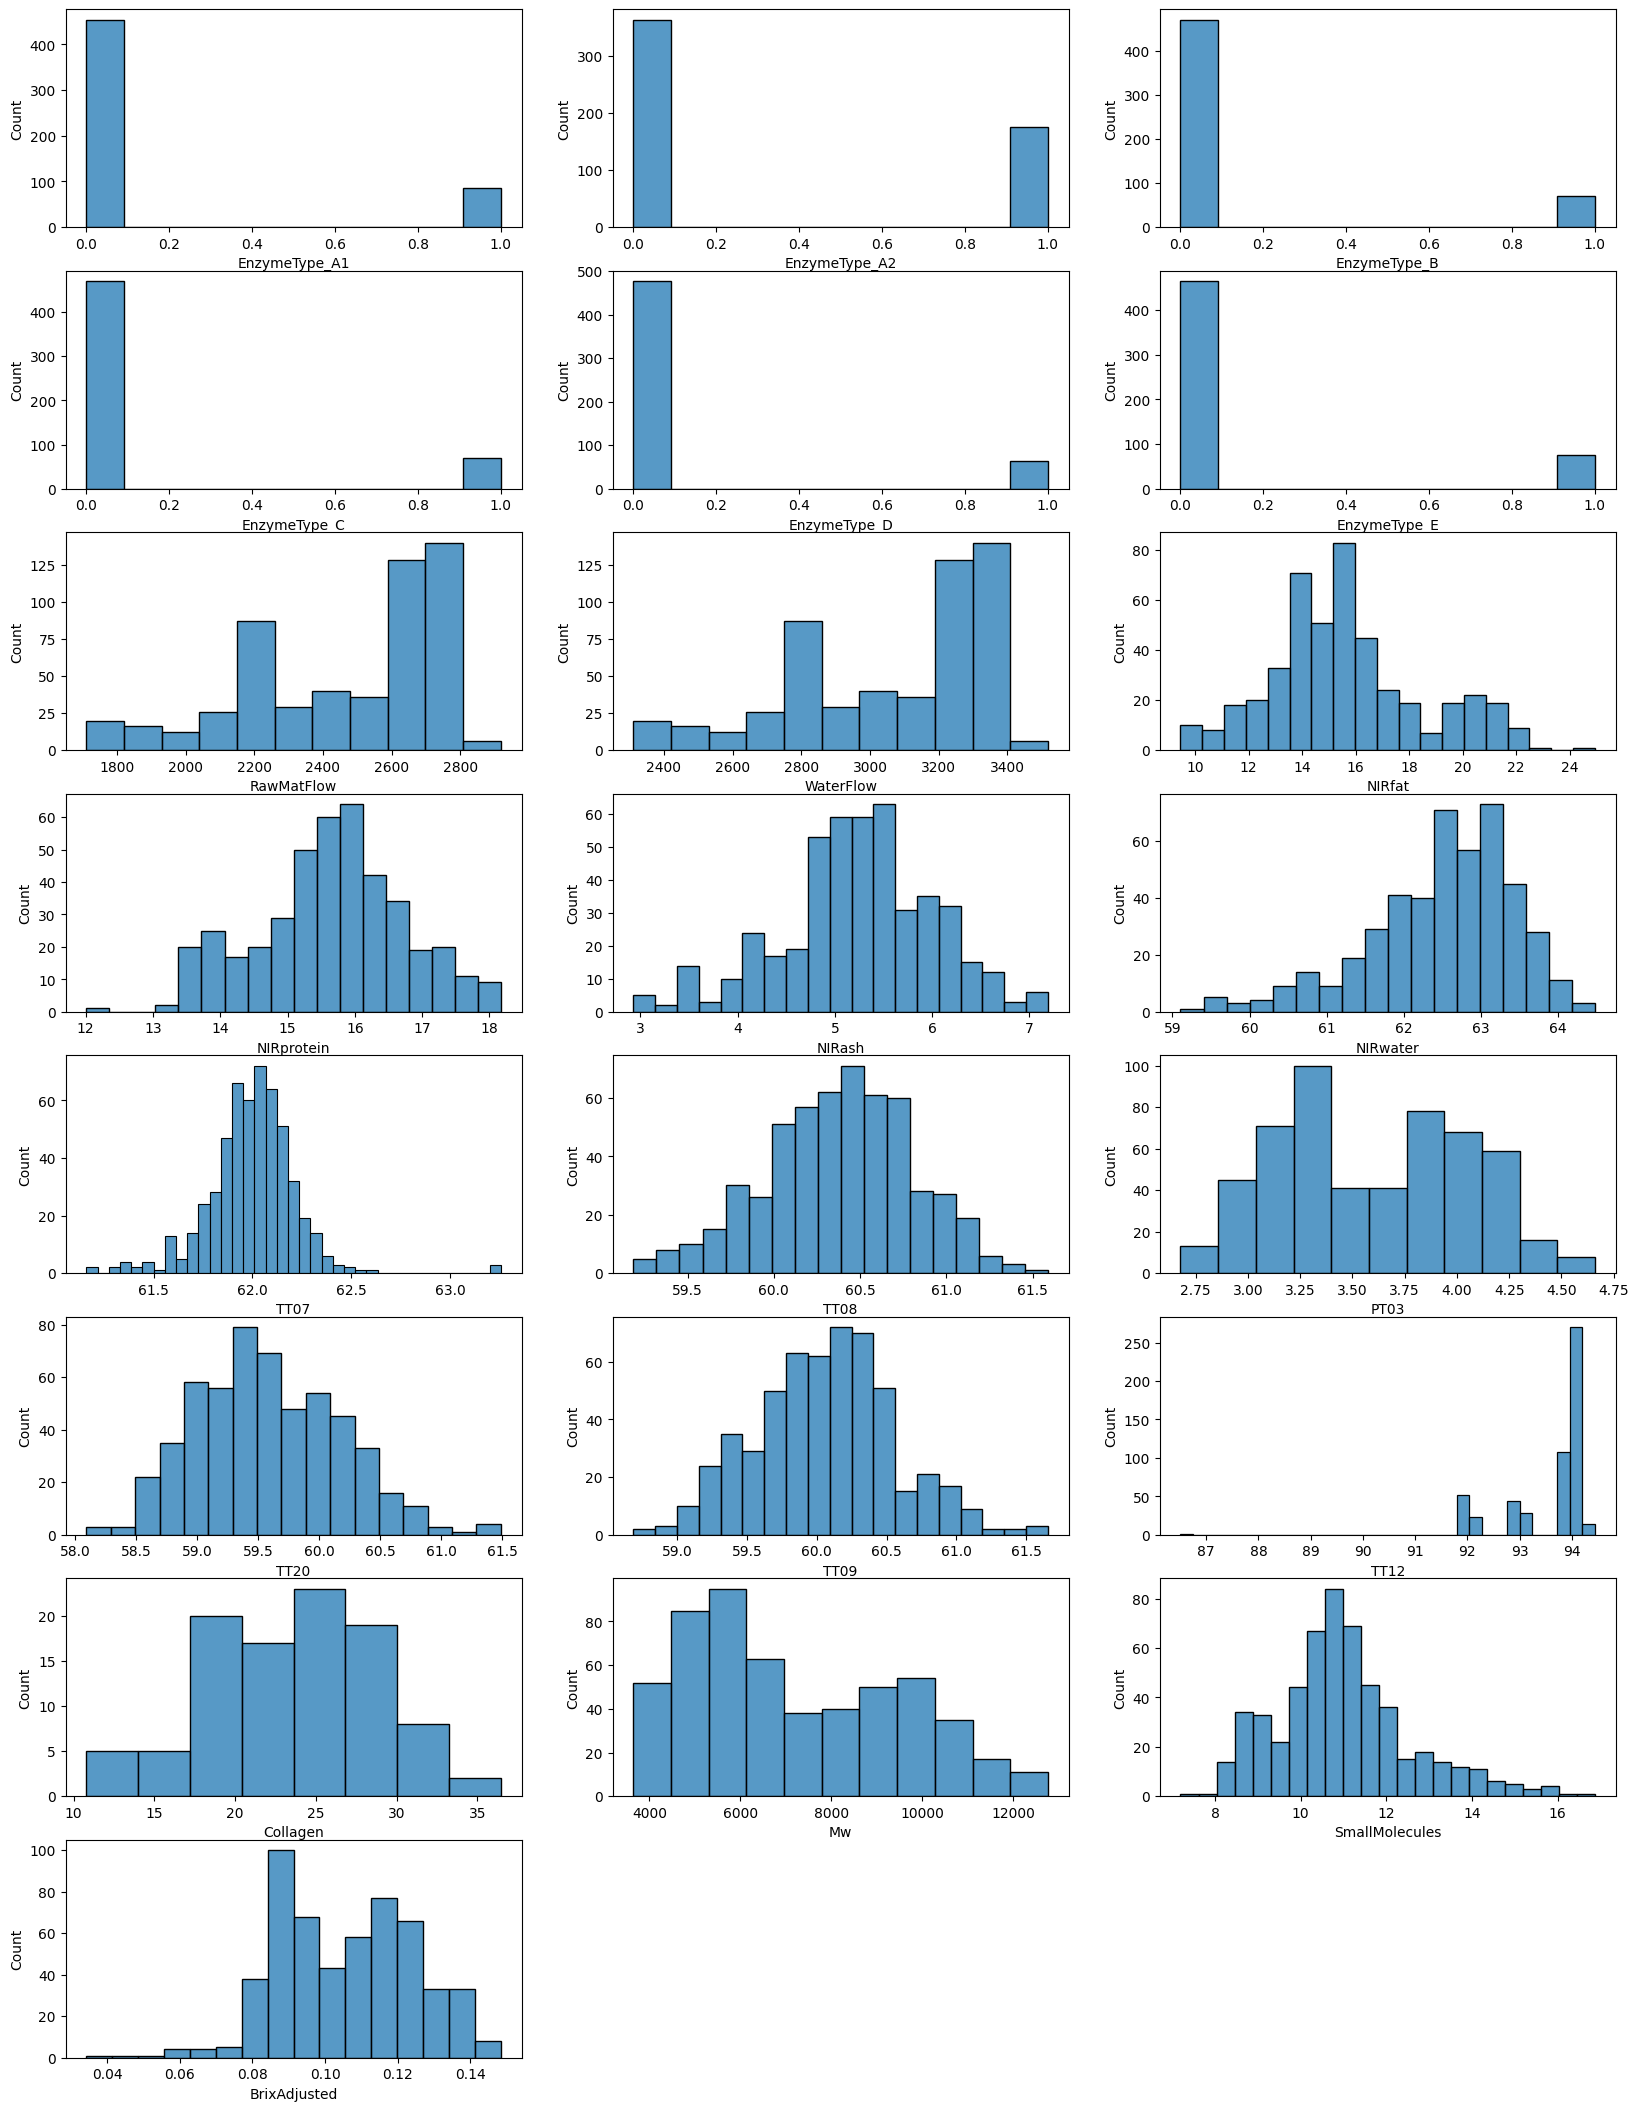

In [12]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(kvalitetsmålinger_markert.columns)
rute_nett = fig.add_gridspec(9,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), kvalitetsmålinger_markert):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.histplot(x=indeks, data = kvalitetsmålinger_markert)
  i += 1

#Korrelasjon

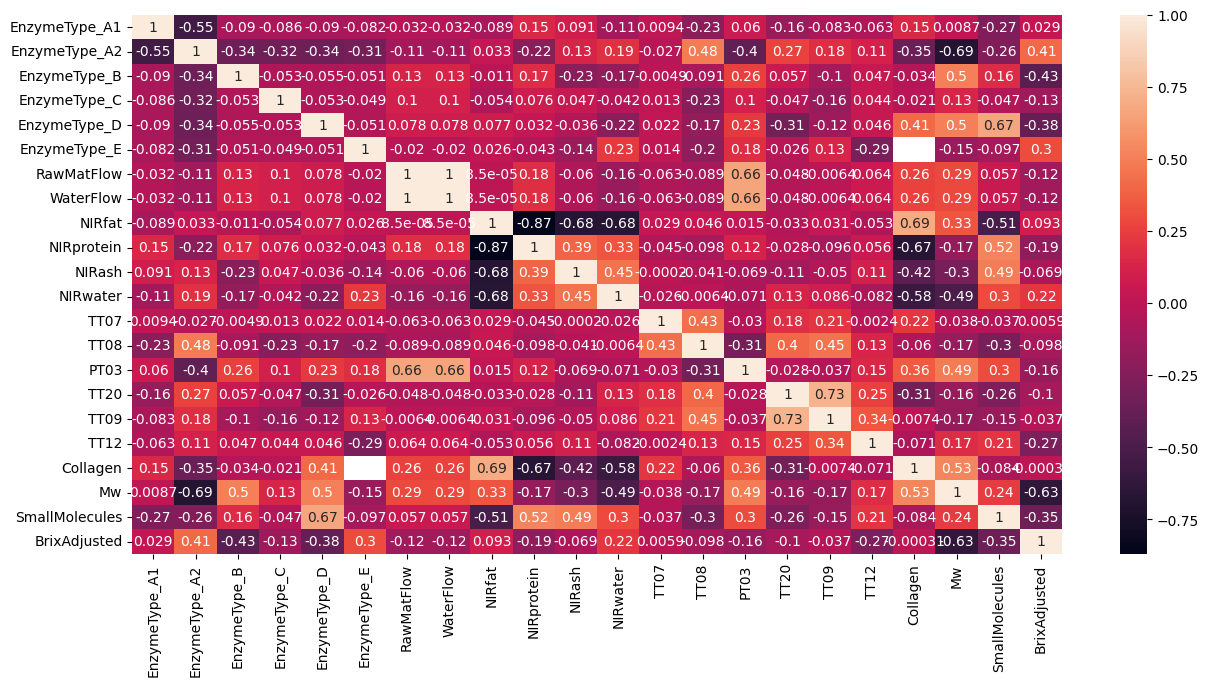

In [13]:
# Lager en korrelasjonsmatrise med annotering
korrelasjon_matrise = bioco_data.corr()
plt.figure(figsize=(15, 7))
sns.heatmap(korrelasjon_matrise, annot=True)
plt.show()

Utelukking av variabler etter vurdering av korrelasjon

In [14]:
# Dropper kolonne "NIRprotein" som er høyt korrelert med NIRfat
bioco_data.drop(columns=['NIRprotein'],
                inplace = True)

# Dropper kolonne "WaterFlow" som er høyt korrelert med RawMatFlow
bioco_data.drop(columns=['WaterFlow'],
                inplace = True)

Lagre førbehandlet data som csv

In [15]:
bioco_data.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/førbehandlet_bioco_data.csv')